https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9

In [3]:
#!pip install folium

In [1]:
import pandas as pd
import folium

In [2]:
#Example for NYC
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

folium.CircleMarker(location=[40.738, -73.98],fill=True).add_to(folium_map)
folium_map

In [3]:
bike_data = pd.read_csv("C:/Users/Maikol Cerda/Downloads/201912-citibike-tripdata.csv")
bike_data.head()

tripduration                 starttime                  stoptime  \
0           602  2019-12-01 00:00:05.5640  2019-12-01 00:10:07.8180   
1          1206  2019-12-01 00:00:10.9630  2019-12-01 00:20:17.8820   
2           723  2019-12-01 00:00:11.8180  2019-12-01 00:12:14.8310   
3           404  2019-12-01 00:00:12.2200  2019-12-01 00:06:56.8860   
4          1059  2019-12-01 00:00:14.7230  2019-12-01 00:17:54.1860   

   start station id      start station name  start station latitude  \
0              3382   Carroll St & Smith St               40.680611   
1               362      Broadway & W 37 St               40.751726   
2               146    Hudson St & Reade St               40.716250   
3              3834  Irving Ave & Halsey St               40.694670   
4               500      Broadway & W 51 St               40.762288   

   start station longitude  end station id              end station name  \
0               -73.994758            3304                  6 Ave & 9 St   
1               -73.987535             500            Broadway & W 51 St   
2               -74.009106             238       Bank St & Washington St   
3               -73.906630            3827          Halsey St & Broadway   
4               -73.983362            3323  W 106 St & Central Park West   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.668127             -73.983776   41932  Subscriber   
1             40.762288             -73.983362   18869    Customer   
2             40.736197             -74.008592   15334  Subscriber   
3             40.685650             -73.915640   41692    Customer   
4             40.798186             -73.960591   40156  Subscriber   

   birth year  gender  
0        1970       1  
1        1999       1  
2        1997       1  
3        1995       1  
4        1961       1

In [4]:
bike_data["starttime"] = pd.to_datetime(bike_data["starttime"])
bike_data["stoptime"] = pd.to_datetime(bike_data["stoptime"])
bike_data["hour"] = bike_data["starttime"].map(lambda x: x.hour)

### pre-processing data
We'll write a function that does the following:

generate a DataFrame containing locations of stations
generates a DataFrame containing the number of trips originating at each station.
generates a DataFrame containing the number of trips arriving at each station.
join the three dataframes into one.

In [5]:
def get_trip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = bike_data.groupby("start station id").first()
    locations = locations.loc[:, ["start station latitude",
                                 "start station longitude",
                                 "start station name"]]
    
    #select one time of day
    subset = bike_data[bike_data["hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("start station id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("end station id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

# print a sample to check our code works
get_trip_counts_by_hour(6).head()

Departure Count  start station latitude  \
start station id                                            
72                             46               40.767272   
79                             28               40.719116   
82                             10               40.711174   
83                              5               40.683826   
116                            61               40.741776   

                  start station longitude             start station name  \
start station id                                                           
72                             -73.993929               W 52 St & 11 Ave   
79                             -74.006667       Franklin St & W Broadway   
82                             -74.000165         St James Pl & Pearl St   
83                             -73.976323  Atlantic Ave & Fort Greene Pl   
116                            -74.001497                W 17 St & 8 Ave   

                  Arrival Count  
start station id                 
72                         56.0  
79                         44.0  
82                         17.0  
83                         30.0  
116                        63.0

Now we'll write a function that generates a new folium map and adds circle markers for each station.

In [6]:
def plot_station_counts(trip_counts):
    # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["start station name"],
                          row["Arrival Count"],
                          row["Departure Count"],
                          net_departures)
        
        # radius of circles
        radius = net_departures/20
        
        # choose the color of the marker
        if net_departures>0:
            # color="#FFCE00" # orange
            # color="#007849" # green
            color="#E37222" # tangerine
        else:
            # color="#0375B4" # blue
            # color="#FFCE00" # yellow            
            color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["start station latitude"],
                                      row["start station longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

Now we’re ready to compare data for some different times of day. Here is the result of running the code we just wrote for two different values of selected_hour.

Now that our data is ready, let’s add it to the map. We’ll iterate over all the rows in the DataFrame we just created and add a marker for each row. We assign a different color depending on the sign of the net departures. If there are more departures than arrivals, we draw a tangerine circle, other wise we use teal.

In [7]:
# plot net departures at 9AM

trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)

In [8]:
# plot net departures at 6PM

trip_counts = get_trip_counts_by_hour(18)
folium_map = plot_station_counts(trip_counts)
folium_map

Cool! Locations that have positive net departures in the morning have net arrivals in the evening. We can see the heartbeat of the city. This could be the starting point for further analysis, perhaps an algorithm to predict arrivals to help the system operator manage the system, or predict bike availability for users looking for a bike. 

Tutorial: Interactive Maps with Python, Part 2
Custom Plots on Geographic Maps
This is part 2 of our 3-part tutorial on interactive maps with python. We are using the NYC bikeshare data as an example. In part 1 we covered how to do basic visualizations with python and folium. Here we will dig a little deeper into how to make custom map overlays.

In part 1, we already noticed some bike migration: at 9am, some regions have more bike departures and different regions have more bike arrivals. In this tutorial we will see if we can show which paths people take. We will put particular emphasis on creating a customized visual appearance. Specifically, we will

customize the effect of overlapping paths to show traffic density, and
we will add a glow effect to draw attention to high density areas. This design is loosly inspired by a map created by facebook [https://newsroom.fb.com/news/2017/06/two-billion-people-coming-together-on-facebook/].
To achieve these effects we will use a raster layer (i.e. and image overlay) and draw our own pixels instead of using the built-in objects in folium to draw the paths (e.g. using PolyLine).

In [9]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

### Creating the intensity map

#### adding lines

We will start by creating a grayscale image where intensity in each pixel is proportional to the number of trips passing through that pixel. We'll use a numpy array to store the pixel values. First we'll write a function that adds a line to an image. We'll start with a new numpy array full of zeros, this will be come our final image. We will then draw a line using pillow on a second canvas and add the resulting pixel values to the existing canvas.

#### Creating Glow Effect

Adding a glow effect to your maps can draw the attention of your audience and instantly focus their attention to certain parts of the map. We will create a glow effect in areas where many lines intersect (high density of traffic). We'll use a convolution filter [https://en.wikipedia.org/wiki/Convolution].

In [10]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

#### Adding color

To convert the map data to colors that are pleasing to the eye, we will apply a saturation function and then apply a color map. This (roughly) mimics the effect of saturation in a photograph or on your retina.

In [11]:

def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out


A quick test of the drawing function
just to demonstrate the effect and check that everything is working

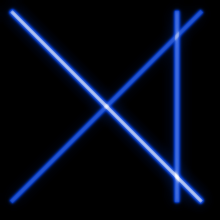

In [12]:

xys = [(10,10,200,200), (175,10,175,200), (200,10,10,200)]  # some lines
weights = np.array([ 2,1,.7])/100  # some weights

# create the image_data
new_image_data = add_lines(np.zeros((220,220)),
                           xys,
                           width=4,
                           weights=weights) 

# show the image
Image.fromarray(to_image(new_image_data),mode="RGBA")

## Plotting bike data
We will visualize every trip by plotting a line as above. Multiple trips will add to show traffic density.
Convert Latitude and Longitude to Pixel Coordinates: Since folium (and leaflet.js) uses Mercator projection we can convert easily from latitude/longitude coordinates to pixel coordinates using a multiplier (i.e., y_pixel = A*latitude, x_pixel= B* longitude). We will choose A and B so that all our paths fit in the image and have the right aspect ratio.


#### Making a stationary plot of the data
We will visualize every trip by plotting a line as above. Multiple trips will add to show traffic density.

#### Convert Latitude and Longitude to Pixel Coordinates
Since folium (and leaflet.js) uses Mercator projection we can convert easily from latitude/longitude coordinates to pixel coordinates using a multiplier (i.e., y_pixel = Alatitude, x_pixel= B longitude). We will choose A and B so that all our paths fit in the image and have the right aspect ratio.

In [13]:
min_lat = bike_data["start station latitude"].min()
max_lat = bike_data["start station latitude"].max()
max_lon = bike_data["start station longitude"].max()
min_lon = bike_data["start station longitude"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["start station latitude"], 
                                       row["start station longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["end station latitude"], 
                                   row["end station longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

Draw all the trips for one time of day

Ok, time to test what we have up to now. Let’s select only those trips that happened between 9 am and 10 am. For speed, we will plot only the first 3000 trips.

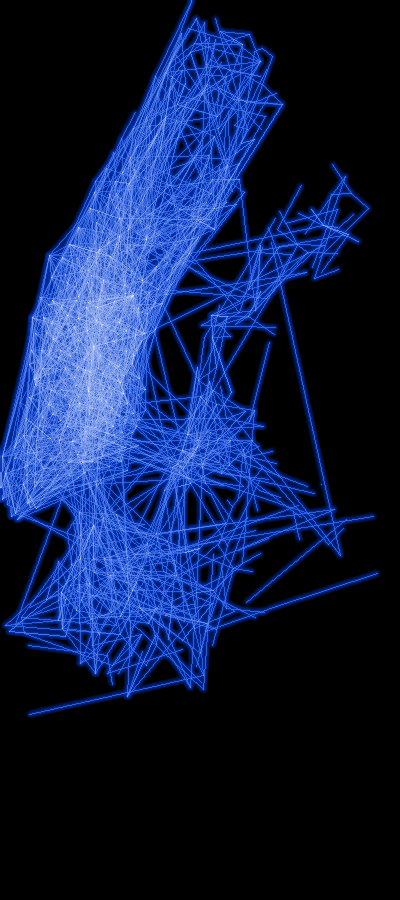

In [14]:
paths = bike_data[bike_data.hour==9]
paths = paths.iloc[:3000,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((900,400))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

Plotting each trip and using line addition is actually a pretty inefficient way to plot all trips. We can use the fact that many trips take the same path to write more efficient code. We’ll leave this as an exercise, but have a look at the Jupyter notebook if you want to see the answer.
Adding an alpha channel: To blend the image we just created with the map, we need to add an alpha channel which controls the transparency of our image. One trick to retain the effect of glow we created is to convert RGB color coordinates to HSV (Hue, Saturation, Value) color coordinates and use the original color value (v) as an alpha channel. If we then set the color value (v) to 1, this creates an image that blends nicely with a black background.
Matplotlib comes with some nice conversion functions from RGB -> HSV and back. Here is the code:

Unique Paths
First we will group individual trips by unique origin and destination. For the first visualization we have in mind this does not make a difference and it will make some of the drawing go much faster. For that we need to do 3 things:

make a dataframe with locations for each station
make a second dataframe with each row representing a unique path
join these two dataframes

In [15]:

# make a list of locations (latitude longitude) for each station id
locations = bike_data.groupby("start station id").mean()
locations = locations.loc[:,["start station latitude", "start station longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
bike_data["path_id"] = [(id1,id2) for id1,id2 in zip(bike_data["start station id"], 
                                                     bike_data["end station id"])]
paths = bike_data[bike_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]>5]
paths["start station id"] = paths.index.map(lambda x:x[0])
paths["end station id"] = paths.index.map(lambda x:x[1])
paths = paths[paths["start station id"]!=paths["end station id"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="start station id")
locations.columns = ["end station latitude","end station longitude"]
paths = paths.join(locations,on="end station id")
paths.index = range(len(paths))

paths.shape

(2174, 7)

In [16]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((900*2,400*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data

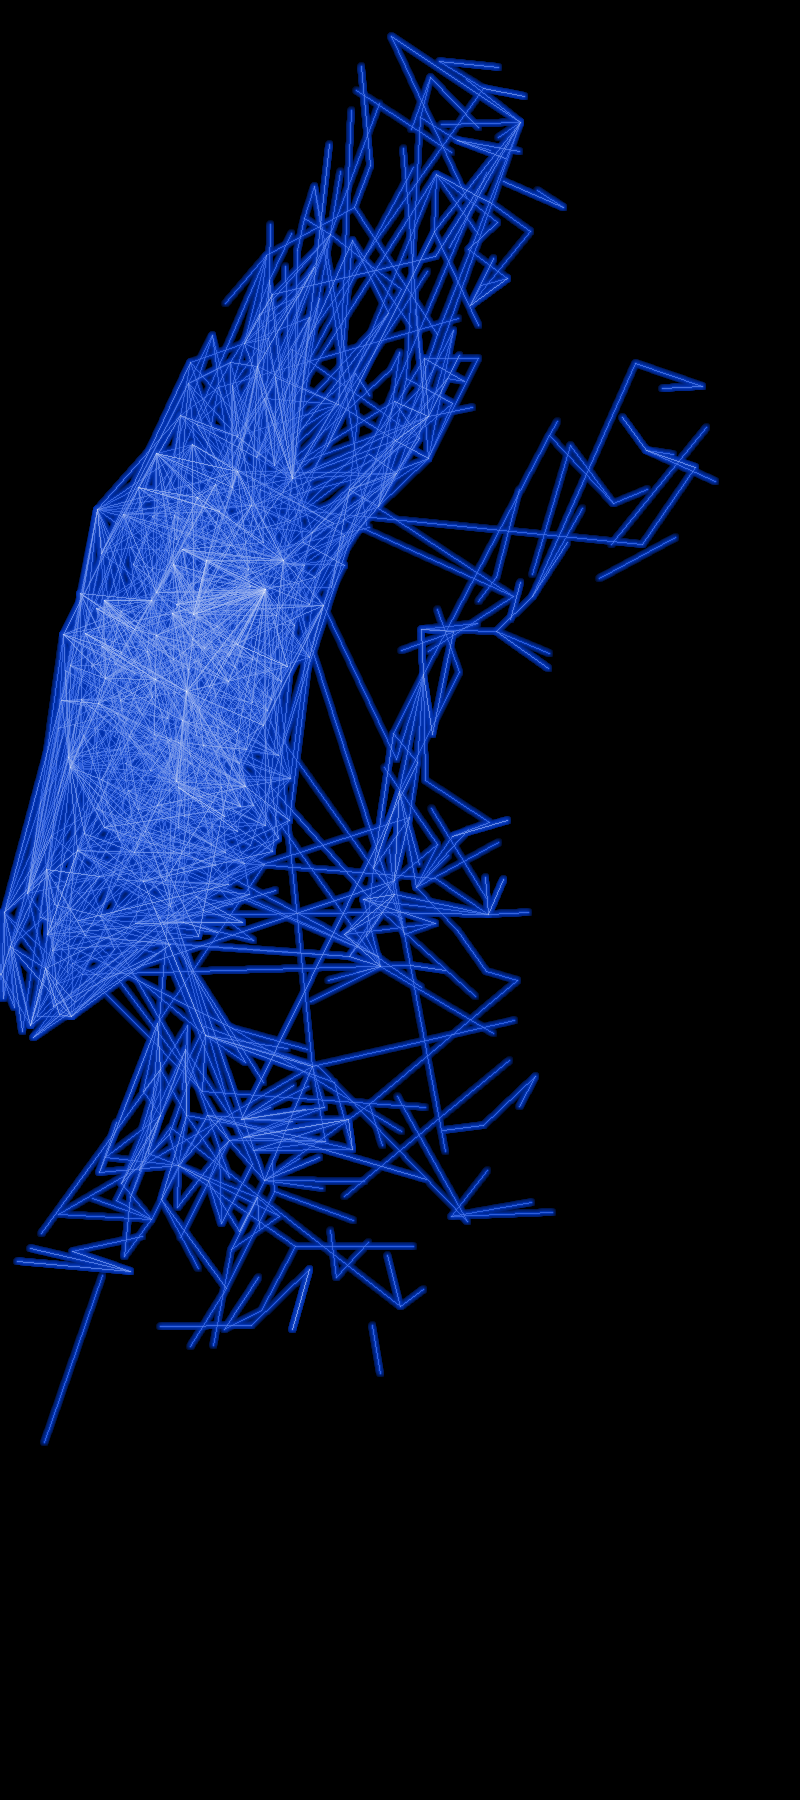

In [17]:
Image.fromarray(to_image(get_image_data(paths)*10)[:,:,:3],mode="RGB")

Adding an alpha channel
To blend the image we just created with the map, we need to add an alpha channel which controls the transparency of our image. One trick to retain the effect of blur/glow we created is that we will convert RGB color coordinates to HSV (Hue, Saturation, Value) color coordinates and use the original color value (v) as an alpha channel and set the color value (v) to 1.

In [18]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

Adding Layers to the Interactive Map
Finally, we will add the RGB image with alpha channel to a folium map. As in part one, we will first create a new map, then create a ImageOverlay layer, and added this layer to map. The code looks like this:

In [19]:
# create the map
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter",
                        width='50%')

# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

We also added a LayerControl component to be able to toggle our image.
To help the user explore the data in more detail, we can add multiple layers and use this LayerControl to toggle between different layers. For example, we can make separate layers for frequently used paths and for infrequently used paths. Again, we will leave the detailed implementation as an exercise, but you can see it in the Jupyter notebook. The result looks like this:

In [20]:

folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter",
                        width='50%')

thresholds = [5,15,25]

for i,t in enumerate(thresholds):
    upper = thresholds[i+1] if i<len(thresholds)-1 else None
    image_data = get_image_data(paths, t, upper)
    name = "{} < Num. Trips < {}".format(t,"max" if upper is None else upper)

    map_overlay = add_alpha(to_image(image_data*10))
    delta_lat = (max_lon-min_lon)/map_overlay.shape[1]*map_overlay.shape[0]*np.cos(min_lat/360*2*np.pi)
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               name = name)

    img.add_to(folium_map)

lc = folium.LayerControl().add_to(folium_map)

folium_map

## Tutorial: Interactive Maps with Python, Part 3

### Animated maps
In this final chapter of our 3-part series, we will set our data in motion. While folium has the capability of showing videos in a browser, we will only export our animations to separate video files (that you can then upload to youtube, etc.)

Let's start with some prerequisites. You'll need to install the selenium package for python:

pip install selenium

#### Update Nov 2018: 

selenium has depricated phantomjs so we will use headless firefox as a driver instead. This means we need to pull the latest version of folium from github as well:

pip install --upgrade git+https://github.com/python-visualization/folium
and you'll need to install phantom.js geckodriver and ffmpeg on your system path. you can download them here:

https://github.com/mozilla/geckodriver/releases/

and here:

https://ffmpeg.org/

In [69]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os.path
import io

import os
os.environ["PATH"] += os.pathsep + "."


%matplotlib inline

We wrote a lot of code in the previous tutorials. I moved some of those functions to a separate file called consolidated_functions. We import it here as 'cf'.

#### Generating frames
The first challenge we run into is that we want to generate movies that vary smoothly in time. This means that we have to generate a sufficiently large number of frames over the (real-world) time span that we want to visualize. Option one is to aggregate the bike data into smaller time intervals, say, every minute. The problem with that approach is that there is a loss of variation in the number of arrivals at each station from minute to minute.
Therefore, we will take a different approach: we will still aggregate by hour but we will interpolate values for intermediate times.

Net arrivals
The first challenge we run into is that we want to generate movies that vary smoothly in time. This means that we have to generate a sufficiently large number of frames over the (real-world) Time span that we want to visualize. Option one is to aggregate the bike data into smaller time intervals, say, every minute. The problem with that approach is that there is a loss of variation in the number of arrivals at each station from minute to minute.

Therefore, we will take a different approach: we will still aggregate by hour but we will interpolate values for intermediate times.

In [22]:

def interpolate(df1, df2, x):
    """return a weighted average of two dataframes"""
    df = df1 * (1 - x) + df2 * x
    return df.replace(np.nan, 0)


def get_trip_counts_by_minute(float_hour, data):
    """get an interpolated dataframe for any time, based
    on hourly data"""
    
    columns = ["start station latitude",
               "start station longitude",
               "Departure Count",
               "Arrival Count"]
    df1 = get_trip_counts_by_hour(int(float_hour))
    df2 = get_trip_counts_by_hour(int(float_hour) + 1)
    
    df = interpolate(df1.loc[:,columns], 
                     df2.loc[:,columns], 
                     float_hour % 1)
    
    df["start station name"] = df1["start station name"]
    return df

We can now generate a map corresponding to a desired time of day (specified as a float). We call the plot_station_countsfunction we wrote in part 1.

We can now generate a map corresponding to a desired time of day (specified as a float). Here is an example:

In [23]:
plot_station_counts(get_trip_counts_by_minute(9.5, bike_data))

We want to create many of these maps in a loop for different times of day. To do that, we need to write a function that takes some settings as input and saves one frame of the movie as an image file. Just before we save the frame to an image file, we also have the opportunity to add some annotations, such as a title and a timestamp. We use Pillow for that, just as we did in part 2. We’ll need to choose and download a font. Have a look at the google font book if you want some inspiration. We will be using Roboto light.

In [24]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_minute(hour_of_day, bike_data)
    my_frame = plot_station_counts(data)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    #font = ImageFont.truetype("Roboto-Light.ttf", 30)
    font = ImageFont.load_default()
    # draw time of day text
    draw.text((20,image.height - 50), 
              "time: {:0>2}:{:0>2}h".format(hour, minutes),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 400,20), 
              "Net Arrivals vs Time of Day",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

In [25]:
#!pip install selenium
#!pip install --upgrade git+https://github.com/python-visualization/folium
#os.environ['PATH']=os.path.expanduser("~/.local/bin")+":"+os.environ['PATH']

Next, we generate a sequence of these frames that we can stitch together into a movie. We call our function in a loop to generate many frames.

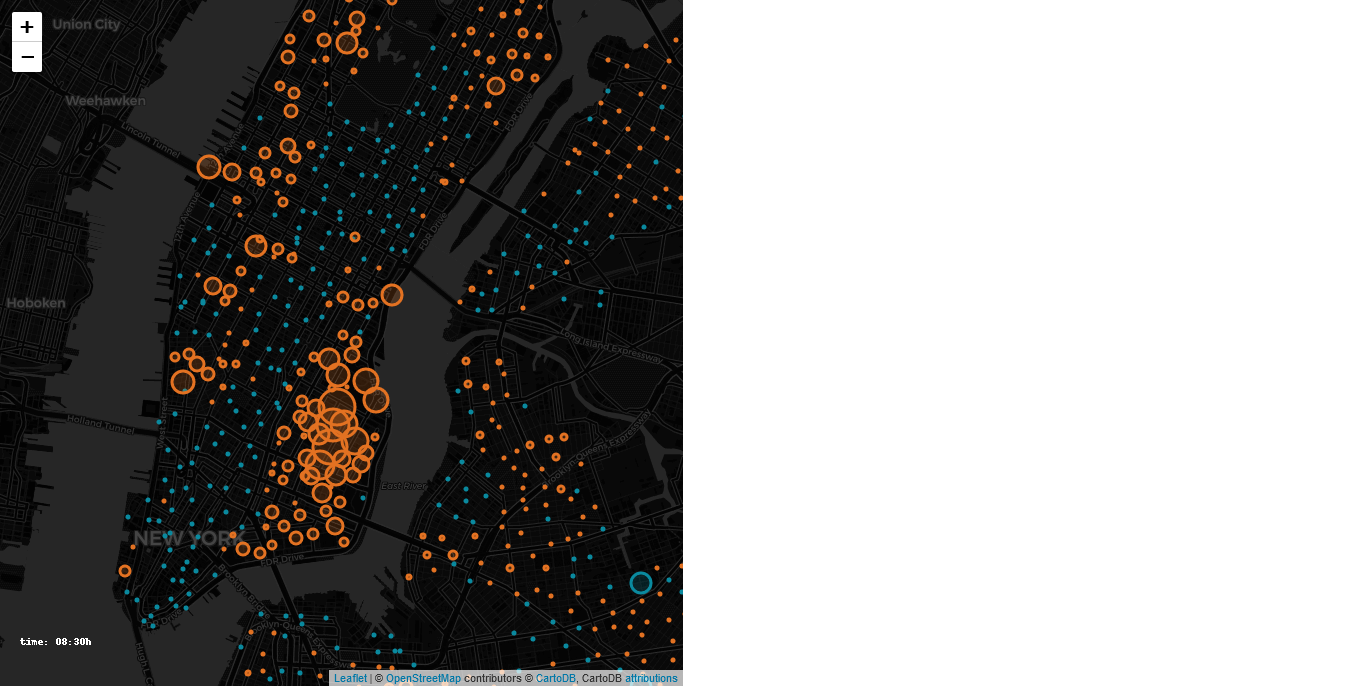

In [26]:
dir_name = 'frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
go_arrivals_frame(1, 8.5, dir_name)


We can convert the resulting images into a movie using ffmpeg (or your favorite video editing program). We will do this from the command line like this:

ffmpeg -r 10 -i frames/frame_%05d.png -c:v libx264 -vf fps=25 -crf 17 -pix_fmt yuv420p output.mp4
Individual Trips
We can now do the same for the individual trips we worked with in part 2. We'll draw the current location of a trip as a glowing dot and draw the path from its origin as glowing (but fainter) line. First we need to do some data pre-processing:

In [27]:
def get_min_max(bike_data):
    min_lat = bike_data["start station latitude"].min()
    max_lat = bike_data["start station latitude"].max()
    max_lon = bike_data["start station longitude"].max()
    min_lon = bike_data["start station longitude"].min()
    return min_lat, max_lat, min_lon, max_lon

def get_path_progress(trips, image_time):
    """ return a series of numbers between 0 and 1 
    indicating the progress of each trip at the given time"""
    
    trip_duration = trips["stoptime"] - trips["starttime"]
    path_progress = (image_time - trips["starttime"]).dt.total_seconds() / trip_duration.dt.total_seconds()
    return path_progress

def get_current_position(trips, progress):
    """ Return Latitude and Longitude for the 'current position' of each trip.
    Paths are assumed to be straight lines between start and end. 
    """
    
    current_latitude = trips["start station latitude"]*(1- progress) + \
                       trips["end station latitude"]* progress
    current_longitude = trips["start station longitude"]*(1- progress) + \
                       trips["end station longitude"]* progress
    return current_latitude, current_longitude


def get_active_trips(image_time, bike_data, image_shape, line_len = .1):
    """ Return pixel coordinates only for trips that have started and 
    not yet completed for the given time.
    """
    
    bounds = get_min_max(bike_data)
    
    active_trips = bike_data[(bike_data["starttime"]<=image_time)]
    active_trips = active_trips[(active_trips["stoptime"]>=image_time)].copy()
    
    progress = get_path_progress(active_trips, image_time)
    
    current_latitude, current_longitude = get_current_position(active_trips, progress)
    start_latitude, start_longitude = get_current_position(active_trips, np.clip(progress-line_len, 0, 1))
    
    start_y, start_x = latlon_to_pixel(start_latitude, 
                                          start_longitude, 
                                          image_shape,
                                          bounds)
    
    end_y, end_x = latlon_to_pixel(current_latitude, 
                                      current_longitude, 
                                      image_shape,
                                      bounds)
    xys = list(zip(start_x, start_y, end_x, end_y))
    weights = np.clip((1 - progress.values)*100, 0, 1)
    
    return xys, weights


As before, we have to convert latitude and longitude to pixel coordinates. We do this with the help of some of the functions we developed in part 2. Note how we changed the function signature (the arguments) a little bit to be able to pass some more parameters.

In [28]:
def latlon_to_pixel(lat, lon, image_shape, bounds):
    min_lat, max_lat, min_lon, max_lon = bounds

    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)

def row_to_pixel(row, image_shape, bounds):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["start latitude"], 
                                          row["start longitude"], 
                                          image_shape,
                                          bounds)
    end_y, end_x = latlon_to_pixel(row["end latitude"], 
                                      row["end longitude"], 
                                      image_shape,
                                      bounds)
    xy = (start_x, start_y, end_x, end_y)
    return xy

Finally, we write a function that generates a folilum map with all the elements that we want.

In [29]:
def get_image_map(frame_time, bike_data):
    """Create the folium map for the given time"""
    
    image_data = np.zeros((900*2,400*2))
    bounds = get_min_max(bike_data)
    
    # plot the current locations
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=.01)
    image_data = add_lines(image_data, xys, weights=weights*20, width = 4)
    
    #  plot the paths
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=1)
    image_data = add_lines(image_data, xys, weights=weights*10, width = 2)
    
    # generate and return the folium map.
    return create_image_map(image_data, bounds)

In [30]:
def create_image_map(image_data, bounds):
    min_lat, max_lat, min_lon, max_lon = bounds
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='100%')

    # create the overlay
    map_overlay = add_alpha(to_image(image_data))

    # compute extent of image in lat/lon
    aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
    delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

    # add the image to the map
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               opacity = 1,
                               name = "Paths")

    img.add_to(folium_map)
    folium.LayerControl().add_to(folium_map)

    # return the map
    return folium_map

In [31]:
get_image_map(pd.to_datetime('2019-12-10 09:00:00'), bike_data)

As we did above with net arrivals, we now write a function that generates one frame.

In [32]:
def go_paths_frame(params):
    """Similar to go_arrivals_frame.
    Generate the image, add annotations, and save image file."""
    i, frame_time = params
    
    my_frame = get_image_map(frame_time, bike_data)
    png = my_frame._to_png()
    
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    font = ImageFont.load_default()
    
    # add date and time of day text
    draw.text((20,image.height - 50), 
              "time: {}".format(frame_time),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 450,20), 
              "Paths of Individual Bike Trips",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    dir_name = "path_frames"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    image.save(os.path.join(dir_name, "frame_{:0>5}.png".format(i)), "PNG")
    return image

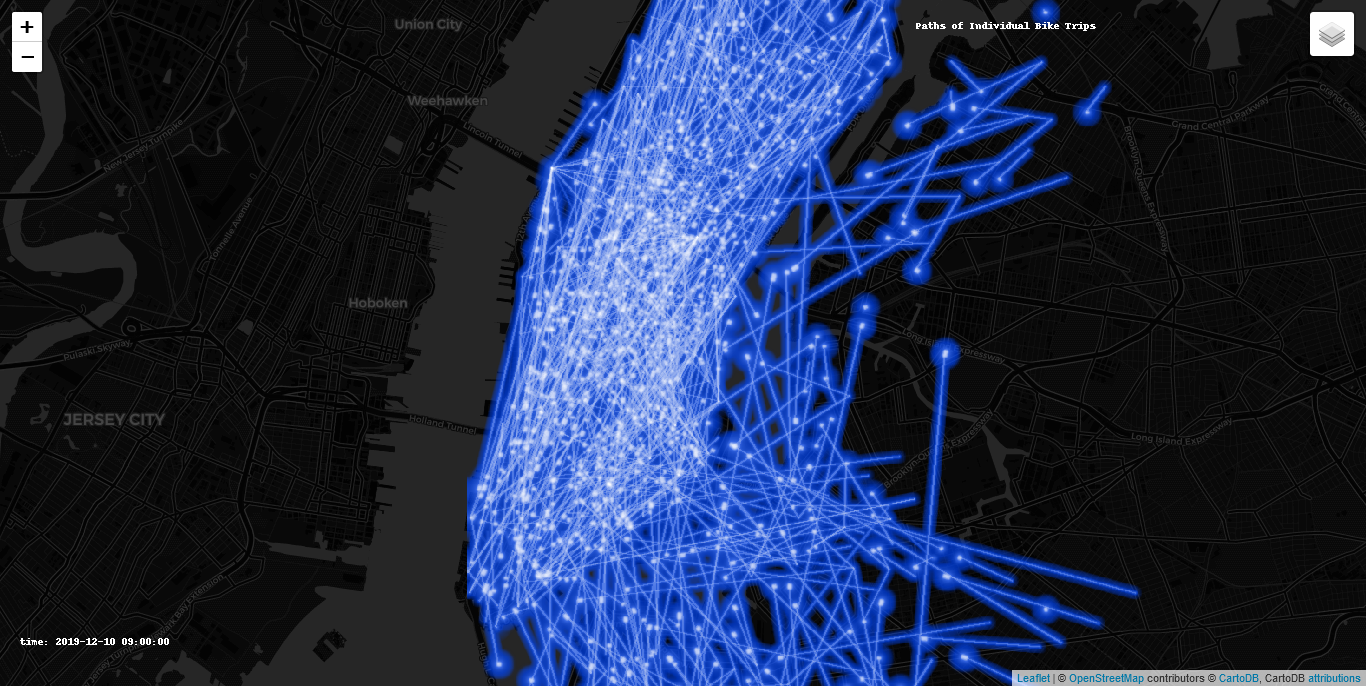

In [33]:
# an example output.
go_paths_frame((1, pd.to_datetime('2019-12-10 09:00:00')))

And now we generate all the frames for the time period we are interested in.

In [34]:
start_time = pd.to_datetime('2019-12-10 09:00:00')
frame_times = [(i, start_time + datetime.timedelta(seconds=30*i)) for i in range(int(120))]

t0 = time.time()
list(map(go_paths_frame,frame_times))
print("time elapsed: {}".format(time.time()-t0))

time elapsed: 7447.255925893784


Make frames for Title Gif
For the header of the totorial article, we want to use an animation that will play automatically in most browsers. We also want it to look smooth, so we will make a GIF with frames that first move forward in time and then backwards.

In [35]:
hours = list(np.arange(6, 10, .2))
hours = hours + hours[::-1]
dir_name = 'gif_frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
for i, hour in enumerate(hours):
    go_arrivals_frame(i, hour, dir_name)

to generate the gif, use ffmpeg. First create a palette:

ffmpeg -y  -t 3 -i frames/frame_%05d.png \
-vf fps=10,scale=320:-1:flags=lanczos,palettegen palette.png
then generate the movie:

ffmpeg -r 10  -i gif_frames/frame_%05d.png -i palette.png -filter_complex \
"fps=10,scale=720:-1:flags=lanczos[x];[x][1:v]paletteuse" header.gif

regenerate some bad frames

In [36]:
arrival_times = np.arange(6, 23, .2)
frames_to_redo = [27, 41, 74]
for i in frames_to_redo:
    hour = arrival_times[i]
    go_arrivals_frame(i, hour, "frames")

In [37]:
frames_to_redo = [61]
for frame in frames_to_redo:
    go_paths_frame(frame_times[frame])

# Second Part

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
# import geojsonio
import folium
import folium.plugins as plugins
import networkx as nx
from sklearn import metrics
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [56]:
df = pd.read_csv("C:/Users/Maikol Cerda/Downloads/201912-citibike-tripdata.csv")
df.head()

tripduration                 starttime                  stoptime  \
0           602  2019-12-01 00:00:05.5640  2019-12-01 00:10:07.8180   
1          1206  2019-12-01 00:00:10.9630  2019-12-01 00:20:17.8820   
2           723  2019-12-01 00:00:11.8180  2019-12-01 00:12:14.8310   
3           404  2019-12-01 00:00:12.2200  2019-12-01 00:06:56.8860   
4          1059  2019-12-01 00:00:14.7230  2019-12-01 00:17:54.1860   

   start station id      start station name  start station latitude  \
0              3382   Carroll St & Smith St               40.680611   
1               362      Broadway & W 37 St               40.751726   
2               146    Hudson St & Reade St               40.716250   
3              3834  Irving Ave & Halsey St               40.694670   
4               500      Broadway & W 51 St               40.762288   

   start station longitude  end station id              end station name  \
0               -73.994758            3304                  6 Ave & 9 St   
1               -73.987535             500            Broadway & W 51 St   
2               -74.009106             238       Bank St & Washington St   
3               -73.906630            3827          Halsey St & Broadway   
4               -73.983362            3323  W 106 St & Central Park West   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.668127             -73.983776   41932  Subscriber   
1             40.762288             -73.983362   18869    Customer   
2             40.736197             -74.008592   15334  Subscriber   
3             40.685650             -73.915640   41692    Customer   
4             40.798186             -73.960591   40156  Subscriber   

   birth year  gender  
0        1970       1  
1        1999       1  
2        1997       1  
3        1995       1  
4        1961       1

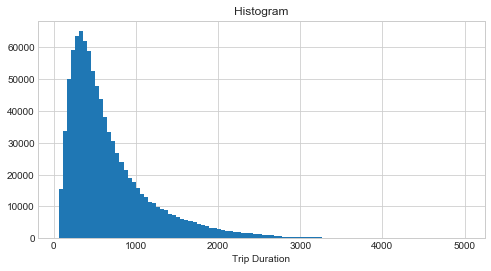

In [57]:
df[df.tripduration<5000].tripduration.hist(bins=100, figsize=(8,4))
plt.xlabel('Trip Duration')
plt.title('Histogram');

In [58]:
# This function is acquired online from:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
def distance(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 6373
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

count    938012.000000
mean          1.585712
std           1.205963
min           0.036747
25%           0.782501
50%           1.239653
75%           1.989133
max           9.997195
Name: distance, dtype: float64

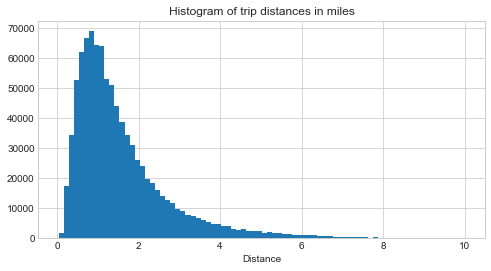

In [59]:
# add a new column for distance calculated
df['distance'] = distance(df['start station latitude'], df['start station longitude'], 
                          df['end station latitude'], df['end station longitude'])
# drop abnormal distance
df = df[df['distance'] <= 10]

# add a new column age
df['age'] = 2018 - df['birth year']

# add a new column age range
df['age range'] = np.where(df['age'] < 20, 'younger than 20', 
                 np.where(df['age'] <= 40, 'between 20 and 40',
                 np.where(df['age'] > 40, 'older than 40', '')))

# add new column - specified gender
df['gender_specified'] = np.where(df['gender'] == 0, 'unknown', 
                 np.where(df['gender'] == 1, 'male',
                 np.where(df['gender'] == 2, 'female', '')))

# drop if distance = 0 but tripduration > 0
df.drop(df[(df['distance'] == 0) & (df['tripduration'] > 0)].index, inplace = True)

# add new column - speed
df['speed'] = df['distance']/ (df['tripduration'] / 60)

#clean format for starttime and endtime:
df['starttime'] = df['starttime'].map(lambda x: x[:-5])
df['stoptime'] = df['stoptime'].map(lambda x: x[:-5])

# histogram of distance without grouping
df.distance.hist(bins=80, figsize=(8,4))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles')
df.distance.describe()

count      mean       std       min       25%       50%  \
gender_specified                                                               
female            209407.0  1.601474  1.182081  0.036747  0.807575  1.264217   
male              684179.0  1.565810  1.208050  0.036747  0.766838  1.216389   
unknown            44426.0  1.817917  1.258754  0.036747  0.926728  1.489169   

                       75%       max  
gender_specified                      
female            2.018459  9.997195  
male              1.954898  9.995124  
unknown           2.380390  9.974766

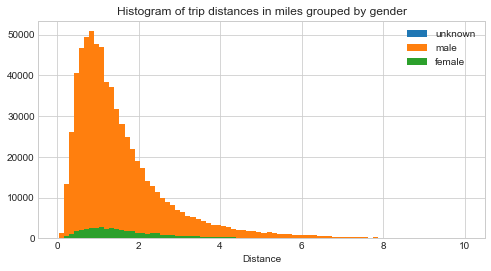

In [60]:
df.groupby('gender_specified').distance.hist(bins=80, figsize=(8,4))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles grouped by gender')
plt.legend(['unknown','male','female'])
df.groupby('gender_specified').distance.describe()

count      mean       std       min       25%       50%  \
age range                                                                       
between 20 and 40  543021.0  1.594026  1.188569  0.036747  0.804716  1.255722   
older than 40      375691.0  1.584679  1.237986  0.036747  0.758071  1.222823   
younger than 20     19300.0  1.371905  1.027263  0.039970  0.697736  1.102955   

                        75%       max  
age range                              
between 20 and 40  1.994253  9.971869  
older than 40      1.996354  9.997195  
younger than 20    1.699529  9.905898

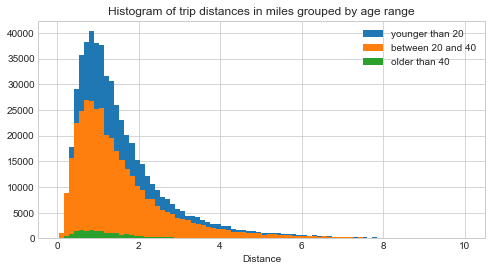

In [61]:
df.groupby('gender_specified')['distance', 'tripduration'].mean()
# calculate the average speed for different gender groups (mile/minute)
speed = (df.groupby('gender_specified')['distance'].mean())/(df.groupby('gender_specified')['tripduration'].mean()/60)

# histogram of distance with grouping of age
df.groupby('age range').distance.hist(bins=80, figsize=(8,4))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles grouped by age range')
plt.legend(['younger than 20','between 20 and 40','older than 40'])
df.groupby('age range').distance.describe()

In [62]:
df['starttime'] = df['starttime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['day_of_week'] = df['starttime'].apply(lambda x: x.weekday()+1) #1-7 representing Mon to Sun
df['pickup_hour'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))
df['pickup_year'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%Y')))
df['pickup_month'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%m')))
# rename weekday, weekend
df['week'] = np.where(df['day_of_week'] < 6, 'weekday', 'weekend')

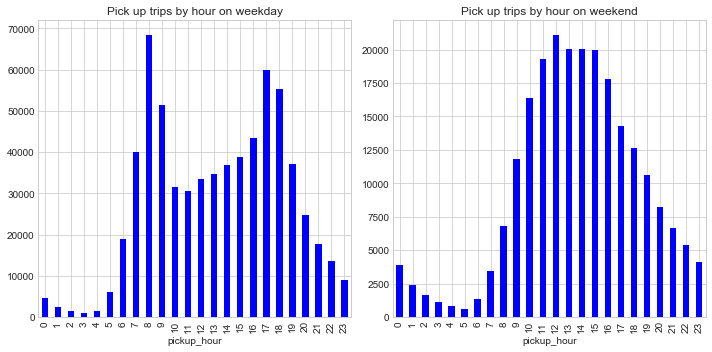

In [63]:
#Annual subscriber: pick up trips by hour

# Redefine the user scope.
df_subscriber=df[df['usertype']=='Subscriber']

# Plot subplots on weekdays and weekend.
COL_NUM=2
ROW_NUM=1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(10,5))

plt.subplot(1,2,1)
df_weekday=df_subscriber[(df_subscriber['day_of_week']!=6)&(df_subscriber['day_of_week']!=7)]
group_weekday = df_weekday.groupby('pickup_hour')
group_weekday.size().plot(kind='bar',title="Pick up trips by hour on weekday",color='b')

plt.subplot(1,2,2)
df_weekend=df[(df['day_of_week']==6)|(df['day_of_week']==7)]
group_weekend = df_weekend.groupby('pickup_hour')
group_weekend.size().plot(kind='bar',title="Pick up trips by hour on weekend",color='b')

plt.tight_layout()

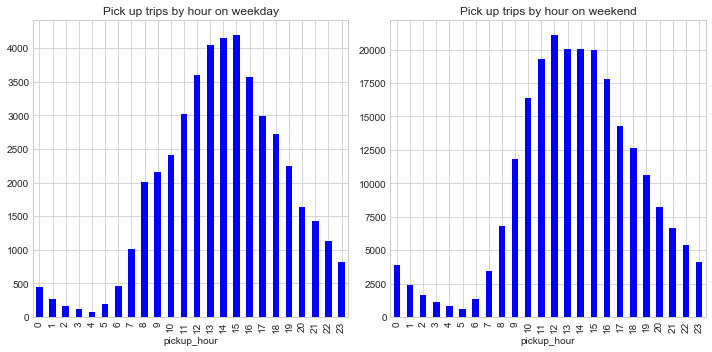

In [64]:
df_customer=df[df['usertype']=='Customer']

COL_NUM=2
ROW_NUM=1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(10,5))

plt.subplot(1,2,1)
df_weekday=df_customer[(df_customer['day_of_week']!=6)&(df_customer['day_of_week']!=7)]
group_weekday = df_weekday.groupby('pickup_hour')
group_weekday.size().plot(kind='bar',title="Pick up trips by hour on weekday",color='b')

plt.subplot(1,2,2)
df_weekend=df[(df['day_of_week']==6)|(df['day_of_week']==7)]
group_weekend = df_weekend.groupby('pickup_hour')
group_weekend.size().plot(kind='bar',title="Pick up trips by hour on weekend",color='b')

plt.tight_layout()

In [65]:

def if_Manhattan_station(latitude,longitude):
    
    # Separate Manhattan into five rectangles to check whether one given point in Manhattan or not.
    # In referrence to the bike distribution in https://member.citibikenyc.com/map/ and 
    
    a1=[(40.6997,40.7080),(-74.0200,-74.0003)]
    a2=[(40.7501,40.8445),(-73.9704,-73.9550)]
    a3=[(40.7080,40.8162),(-74.0200,-73.9704)]
    a4=[(40.7641,40.8445),(-73.9550,-73.9418)]
    a5=[(40.7836,40.8445),(-73.9418,-73.9273)] 
    a6=[(40.7232,40.7609),(-73.9846,-73.9639)]
    
    # Start checking
    if ((a1[0][0]<=latitude<=a1[0][1]) & (a1[1][0]<=longitude<=a1[1][1]))\
    or ((a2[0][0]<=latitude<=a2[0][1]) & (a2[1][0]<=longitude<=a2[1][1]))\
    or ((a3[0][0]<=latitude<=a3[0][1]) & (a3[1][0]<=longitude<=a3[1][1]))\
    or ((a4[0][0]<=latitude<=a4[0][1]) & (a4[1][0]<=longitude<=a4[1][1]))\
    or ((a5[0][0]<=latitude<=a5[0][1]) & (a5[1][0]<=longitude<=a5[1][1]))\
    or ((a6[0][0]<=latitude<=a6[0][1]) & (a6[1][0]<=longitude<=a6[1][1]))\
    or (latitude==40.750020)&(longitude==-73.969053): 
    
        return 1 # point within Manhattan
    else:
        return 0 # point out of Manhattan

In [66]:
df_weekday=df[(df['day_of_week']!=6)&(df['day_of_week']!=7)]
df_weekday['start station latitude'].astype(float)
df_weekday['start station longitude'].astype(float)
# add column to check whether start and end station in Manhattan or not
df_weekday['if_start_Manhattan']=df_weekday.apply(lambda x: if_Manhattan_station(x['start station latitude'],x['start station longitude']),axis=1)
df_weekday['if_end_Manhattan']=df_weekday.apply(lambda x: if_Manhattan_station(x['end station latitude'],x['end station longitude']),axis=1)

df_weekday['stoptime'] = df_weekday['stoptime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_weekday['end_hour'] = df_weekday['stoptime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))

# separate trip according to direction(Manhattan<->outer borough)
df_Manhattan_out=df_weekday[(df_weekday['if_start_Manhattan']==1)&(df_weekday['if_end_Manhattan']==0)]
df_Manhattan_in=df_weekday[(df_weekday['if_start_Manhattan']==0)&(df_weekday['if_end_Manhattan']==1)]

# calculate number of trips per hour based on different directions.
out_count_byhour=dict()
for i in range(24):
    out_count_byhour[i]=df_Manhattan_out[(df_Manhattan_out['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_out['end_hour'])]['tripduration'].count()

in_count_byhour=dict()
for i in range(24):
    in_count_byhour[i]=df_Manhattan_in[(df_Manhattan_in['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_in['end_hour'])]['tripduration'].count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

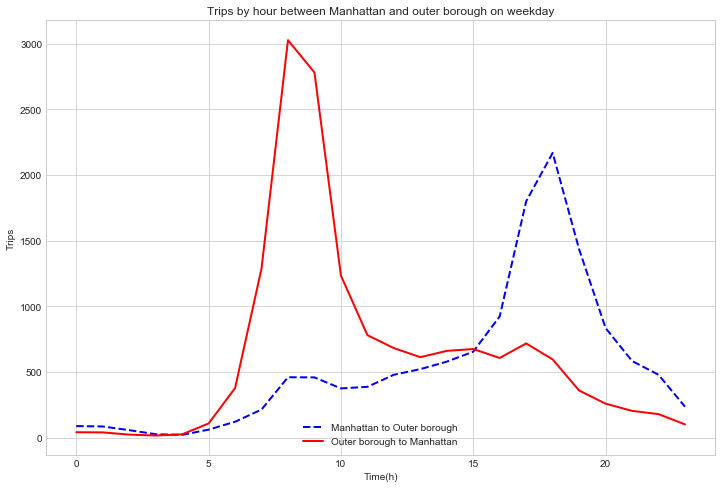

In [82]:
#Plot chart
x1 = out_count_byhour.keys()
y1 = out_count_byhour.values()
x2 = in_count_byhour.keys()
y2 = in_count_byhour.values()

plt.figure(figsize=(12,8)) 
plt.plot([*x1],[*y1],"b--",linewidth=2,label='Manhattan to Outer borough')
plt.plot([*x2],[*y2],"r-",linewidth=2,label='Outer borough to Manhattan')
plt.legend(loc='lower center')
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour between Manhattan and outer borough on weekday")
plt.show()


In [53]:
df_weekend=df[(df['day_of_week']==6)|(df['day_of_week']==7)]

df_weekend['if_start_Manhattan']=df_weekend.apply(lambda x: if_Manhattan_station(x['start station latitude'],x['start station longitude']),axis=1)
df_weekend['if_end_Manhattan']=df_weekend.apply(lambda x: if_Manhattan_station(x['end station latitude'],x['end station longitude']),axis=1)

df_weekend['stoptime'] = df_weekend['stoptime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_weekend['end_hour'] = df_weekend['stoptime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))

df_Manhattan_out=df_weekend[(df_weekend['if_start_Manhattan']==1)&(df_weekend['if_end_Manhattan']==0)]
df_Manhattan_in=df_weekend[(df_weekend['if_start_Manhattan']==0)&(df_weekend['if_end_Manhattan']==1)]

out_count_byhour=dict()
for i in range(24):
    out_count_byhour[i]=df_Manhattan_out[(df_Manhattan_out['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_out['end_hour'])]['tripduration'].count()

in_count_byhour=dict()
for i in range(24):
    in_count_byhour[i]=df_Manhattan_in[(df_Manhattan_in['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_in['end_hour'])]['tripduration'].count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

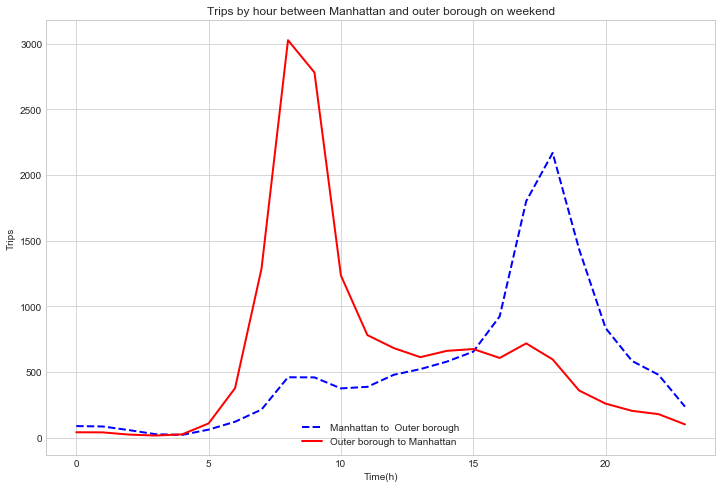

In [84]:
x1 = out_count_byhour.keys()
y1 = out_count_byhour.values()
x2 = in_count_byhour.keys()
y2 = in_count_byhour.values()
plt.figure(figsize=(12,8)) 
plt.plot([*x1],[*y1],"b--",linewidth=2,label='Manhattan to  Outer borough')
plt.plot([*x2],[*y2],"r-",linewidth=2,label='Outer borough to Manhattan')
plt.legend(loc='lower center')
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour between Manhattan and outer borough on weekend")
plt.show()